In [426]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.datasets import get_rdataset
from statsmodels.regression import linear_model as lm
from statsmodels.discrete import discrete_model as dm
from statsmodels.tools import add_constant
from statsmodels.stats import anova

from sklearn.preprocessing import PolynomialFeatures

from patsy import dmatrix, cr, bs

from loess import loess_1d

## Polynomial Regression

In [2]:
df = get_rdataset("Wage", "ISLR", cache=True).data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 231655 to 453557
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        3000 non-null   int64  
 1   age         3000 non-null   int64  
 2   maritl      3000 non-null   object 
 3   race        3000 non-null   object 
 4   education   3000 non-null   object 
 5   region      3000 non-null   object 
 6   jobclass    3000 non-null   object 
 7   health      3000 non-null   object 
 8   health_ins  3000 non-null   object 
 9   logwage     3000 non-null   float64
 10  wage        3000 non-null   float64
dtypes: float64(2), int64(2), object(7)
memory usage: 281.2+ KB


In [4]:
df.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
231655,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
86582,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
161300,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
155159,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
11443,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [7]:
print(df.maritl.unique())
print(df.race.unique())
print(df.education.unique())
print(df.region.unique())
print(df.jobclass.unique())
print(df.health.unique())
print(df.health_ins.unique())

['1. Never Married' '2. Married' '4. Divorced' '3. Widowed' '5. Separated']
['1. White' '3. Asian' '4. Other' '2. Black']
['1. < HS Grad' '4. College Grad' '3. Some College' '2. HS Grad'
 '5. Advanced Degree']
['2. Middle Atlantic']
['1. Industrial' '2. Information']
['1. <=Good' '2. >=Very Good']
['2. No' '1. Yes']


<AxesSubplot:xlabel='age'>

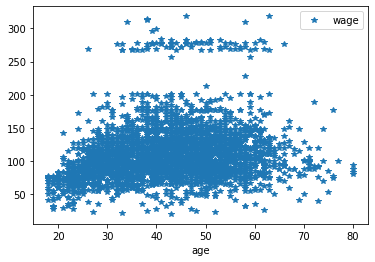

In [33]:
df.plot(x="age", y="wage", ls="", marker="*")

In [53]:
print(
    np.polyfit(x=df.age, y=df.wage, deg=4)
)

[-3.20383037e-05  6.81068771e-03 -5.63859313e-01  2.12455205e+01
 -1.84154180e+02]


In [83]:
pol_age = pd.DataFrame(data=PolynomialFeatures(degree=4).fit_transform(df.age.to_numpy().reshape(-1,1)),
                      columns=["INTERCEPT"] + [f"AGE^{i}" for i in range(1,5)])
pol_age.index=df.wage.index

In [84]:
pol_age

,INTERCEPT,AGE^1,AGE^2,AGE^3,AGE^4
231655,1.0,18.0,324.0,5832.0,104976.0
86582,1.0,24.0,576.0,13824.0,331776.0
161300,1.0,45.0,2025.0,91125.0,4100625.0
155159,1.0,43.0,1849.0,79507.0,3418801.0
11443,1.0,50.0,2500.0,125000.0,6250000.0
...,...,...,...,...,...
376816,1.0,44.0,1936.0,85184.0,3748096.0
302281,1.0,30.0,900.0,27000.0,810000.0
10033,1.0,27.0,729.0,19683.0,531441.0
14375,1.0,27.0,729.0,19683.0,531441.0


In [85]:
model = lm.OLS(df.wage, pol_age).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     70.69
Date:                Fri, 01 Jul 2022   Prob (F-statistic):           2.77e-57
Time:                        10:07:13   Log-Likelihood:                -15315.
No. Observations:                3000   AIC:                         3.064e+04
Df Residuals:                    2995   BIC:                         3.067e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
INTERCEPT   -184.1542     60.040     -3.067      0.0

In [91]:
grid = np.arange(min(df.age), max(df.age)+1)

In [103]:
pol_grid = pd.DataFrame(data=PolynomialFeatures(degree=4).fit_transform(grid.reshape(-1,1)),
                      columns=["INTERCEPT"] + [f"AGE^{i}" for i in range(1,5)])
pred = model.predict(pol_grid)


Text(0.5, 0, 'Age')

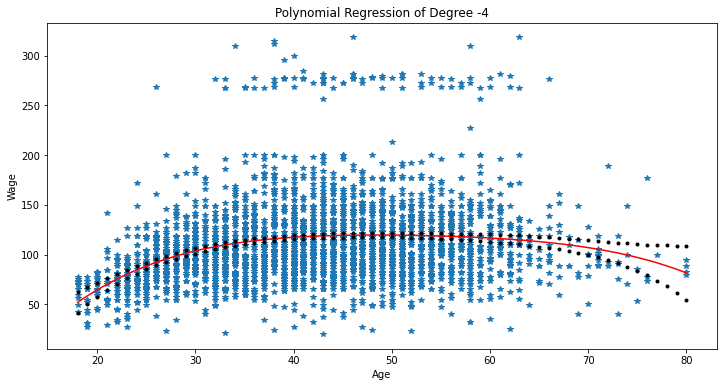

In [128]:
plt.figure(figsize=(12,6))
plt.plot(df.age, df.wage, "*")
plt.plot(grid, pred.predicted_mean, "r-", 
         grid, pred.predicted_mean - 2*pred.se_mean, "k.",
        grid, pred.predicted_mean + 2*pred.se_mean, "k.")
plt.title("Polynomial Regression of Degree -4")
plt.ylabel("Wage")
plt.xlabel("Age")

In [135]:
pols = [pd.DataFrame(
            data = PolynomialFeatures(degree=i).fit_transform( df.age.to_numpy().reshape(-1, 1) ),
            columns = ["Intercept"] + [f"Age^{j}" for j in range(1,i+1)],
            index = df.index
         ) for i in range(1,5+1)]
models = [lm.OLS(df.wage, pol).fit() for pol in pols]
anova.anova_lm(*models)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


In [159]:
df["bin_wage"] = df.wage.apply(lambda x: x>250)
df.bin_wage = df.bin_wage.apply(lambda x: int(x))

In [176]:
pols[3]

,Intercept,Age^1,Age^2,Age^3,Age^4
231655,1.0,18.0,324.0,5832.0,104976.0
86582,1.0,24.0,576.0,13824.0,331776.0
161300,1.0,45.0,2025.0,91125.0,4100625.0
155159,1.0,43.0,1849.0,79507.0,3418801.0
11443,1.0,50.0,2500.0,125000.0,6250000.0
...,...,...,...,...,...
376816,1.0,44.0,1936.0,85184.0,3748096.0
302281,1.0,30.0,900.0,27000.0,810000.0
10033,1.0,27.0,729.0,19683.0,531441.0
14375,1.0,27.0,729.0,19683.0,531441.0


In [161]:
model = dm.Logit(df.bin_wage, pols[3]).fit()

Optimization terminated successfully.
         Current function value: 0.116870
         Iterations 12


In [163]:
print(model.summary())

                           Logit Regression Results                           
Dep. Variable:               bin_wage   No. Observations:                 3000
Model:                          Logit   Df Residuals:                     2995
Method:                           MLE   Df Model:                            4
Date:                Fri, 01 Jul 2022   Pseudo R-squ.:                 0.04013
Time:                        11:27:06   Log-Likelihood:                -350.61
converged:                       True   LL-Null:                       -365.27
Covariance Type:            nonrobust   LLR p-value:                 6.747e-06
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -109.5530     47.655     -2.299      0.022    -202.956     -16.150
Age^1          8.9950      4.187      2.148      0.032       0.789      17.201
Age^2         -0.2816      0.135     -2.081      0.0

<AxesSubplot:xlabel='age'>

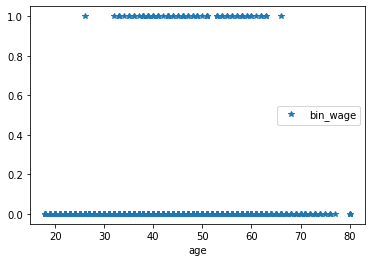

In [167]:
df.plot(x="age", y="bin_wage", ls="", marker="*")

In [223]:
model2 = sm.GLM(df.wage>250, pols[3], family=sm.families.Binomial()).fit()
pred = model2.get_prediction(pol_grid, transform=False)

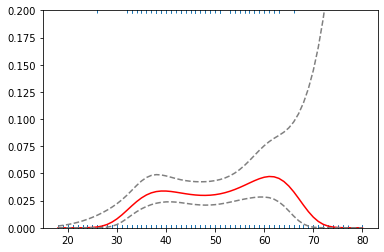

In [232]:
#plt.figure(figsize=(4,5))
plt.ylim((0,0.2))
plt.plot(df.age, df.bin_wage/5, "|")
plt.plot(grid, pred.predicted_mean, "r-")
plt.plot(grid, pred.conf_int(), c="gray", ls="--")

## Step Functions

In [235]:
df_cuts, bins = pd.cut(df.age, bins=4, retbins=True)

In [236]:
bins

array([17.938, 33.5  , 49.   , 64.5  , 80.   ])

In [238]:
df_cuts.value_counts()

(33.5, 49.0]      1399
(49.0, 64.5]       779
(17.938, 33.5]     750
(64.5, 80.0]        72
Name: age, dtype: int64

In [241]:
df_cuts

231655    (17.938, 33.5]
86582     (17.938, 33.5]
161300      (33.5, 49.0]
155159      (33.5, 49.0]
11443       (49.0, 64.5]
               ...      
376816      (33.5, 49.0]
302281    (17.938, 33.5]
10033     (17.938, 33.5]
14375     (17.938, 33.5]
453557      (49.0, 64.5]
Name: age, Length: 3000, dtype: category
Categories (4, interval[float64, right]): [(17.938, 33.5] < (33.5, 49.0] < (49.0, 64.5] < (64.5, 80.0]]

In [242]:
model = lm.OLS(df.wage, pd.get_dummies(df_cuts)).fit()

In [244]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     66.58
Date:                Fri, 01 Jul 2022   Prob (F-statistic):           1.13e-41
Time:                        12:32:19   Log-Likelihood:                -15353.
No. Observations:                3000   AIC:                         3.071e+04
Df Residuals:                    2996   BIC:                         3.074e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
(17.938, 33.5]    94.1584      1.476     63.

In [252]:
pd.concat([df.age, df_cuts, df.wage], keys = ['age','age_cuts','wage'], axis = 1)

,age,age_cuts,wage
231655,18,"(17.938, 33.5]",75.043154
86582,24,"(17.938, 33.5]",70.476020
161300,45,"(33.5, 49.0]",130.982177
155159,43,"(33.5, 49.0]",154.685293
11443,50,"(49.0, 64.5]",75.043154
...,...,...,...
376816,44,"(33.5, 49.0]",154.685293
302281,30,"(17.938, 33.5]",99.689464
10033,27,"(17.938, 33.5]",66.229408
14375,27,"(17.938, 33.5]",87.981033


In [257]:
pd.get_dummies(df_cuts).head()

,"(17.938, 33.5]","(33.5, 49.0]","(49.0, 64.5]","(64.5, 80.0]"
231655,1,0,0,0
86582,1,0,0,0
161300,0,1,0,0
155159,0,1,0,0
11443,0,0,1,0


In [258]:
df_cuts_cat = add_constant(pd.get_dummies(df_cuts, drop_first=1))

In [281]:
df_cuts_cat.columns[1]

Interval(33.5, 49.0, closed='right')

In [259]:
df_cuts_cat.head()

,const,"(33.5, 49.0]","(49.0, 64.5]","(64.5, 80.0]"
231655,1.0,0,0,0
86582,1.0,0,0,0
161300,1.0,1,0,0
155159,1.0,1,0,0
11443,1.0,0,1,0


In [260]:
model = sm.GLM(df.wage, df_cuts_cat).fit()

In [262]:
model.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
const,94.1584,1.476,63.790,0.000,91.265,97.051
"(33.5, 49.0]",24.0535,1.829,13.148,0.000,20.468,27.639
"(49.0, 64.5]",23.6646,2.068,11.443,0.000,19.611,27.718
"(64.5, 80.0]",7.6406,4.987,1.532,0.126,-2.135,17.416


In [267]:
grid

array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80])

In [305]:
def cat(x):
    if x<=33.5:
        return pd.Interval(left = -np.inf, right=33.5)
    elif x<=49:
        return pd.Interval(33.5, 49)
    elif x<=64.5:
        return pd.Interval(49, 64.5)
    elif x<=80:
        return pd.Interval(64.5, 80)
    else:
        return pd.Interval(left=80, right=np.inf)

In [335]:
model = sm.GLM(df.wage, df_cuts_cat).fit()
pred = model.get_prediction(add_constant(pd.get_dummies(list(map(cat, grid)), drop_first=True)), transform=False)

model2 = sm.GLM(df.wage>250, df_cuts_cat, family=sm.families.Binomial()).fit()
grid_cat = add_constant(pd.get_dummies(list(map(cat, grid)), drop_first=True))
pred2 = model2.get_prediction(grid_cat, transform=False)

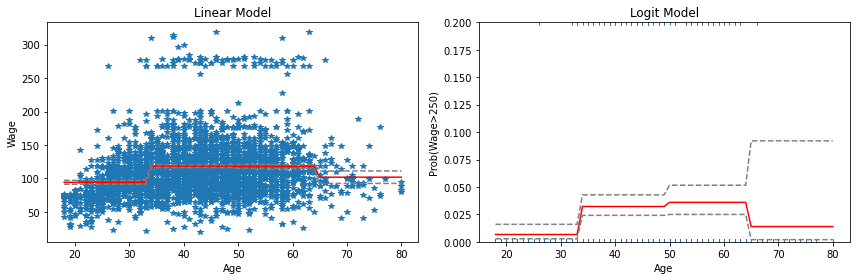

In [341]:
f, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(df.age, df.wage, "*")
ax[0].plot(grid, pred.predicted_mean, "r")
ax[0].plot(grid, pred.conf_int(), c="gray", ls="--")
ax[0].set_title("Linear Model")
ax[0].set_ylabel("Wage")
ax[0].set_xlabel("Age")

ax[1].set_ylim((0,0.2))
ax[1].plot(df.age, (df.wage>250)/5, "|")
ax[1].plot(grid, pred2.predicted_mean, "r-")
ax[1].plot(grid, pred2.conf_int(), c="gray", ls="--")
ax[1].set_title("Logit Model")
ax[1].set_ylabel("Prob(Wage>250)")
ax[1].set_xlabel("Age")

f.tight_layout()

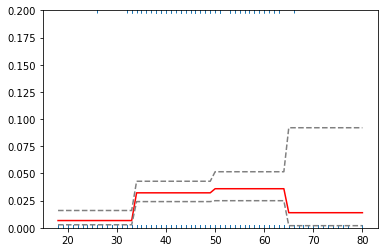

In [331]:
#plt.figure(figsize=(4,5))


## Splines

In [380]:
splined_age = dmatrix("bs(train, knots=(25,40,60), degree=3, include_intercept=True)",
        {"train": df.age},return_type='dataframe')

In [381]:
model = sm.GLM(df.wage, splined_age).fit()

In [382]:
X = dmatrix("bs(train, knots=(25,40,60), degree=3, include_intercept=True)",
        {"train": grid},return_type='dataframe')
pred = model.get_prediction(X)

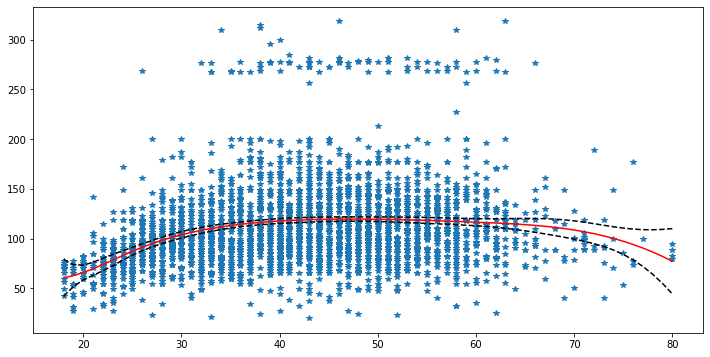

In [383]:
plt.figure(figsize=(12,6))
plt.plot(df.age, df.wage, "*")
plt.plot(grid, pred.predicted_mean, "r")
plt.plot(grid, pred.conf_int(), "k--")

In [390]:
natural_splines = dmatrix("cr(train, df=4)",
        {"train": df.age},return_type='dataframe')

In [391]:
natural_splines

,Intercept,"cr(train, df=4)[0]","cr(train, df=4)[1]","cr(train, df=4)[2]","cr(train, df=4)[3]"
231655,1.0,1.000000,0.000000,0.000000,0.000000
86582,1.0,0.627430,0.462418,-0.105556,0.015708
161300,1.0,-0.080345,0.756695,0.372737,-0.049087
155159,1.0,-0.072389,0.856210,0.251241,-0.035062
11443,1.0,-0.065013,0.454076,0.679982,-0.069045
...,...,...,...,...,...
376816,1.0,-0.077620,0.808722,0.311189,-0.042290
302281,1.0,0.297924,0.828456,-0.148474,0.022094
10033,1.0,0.454603,0.663508,-0.138759,0.020649
14375,1.0,0.454603,0.663508,-0.138759,0.020649


In [392]:
model = sm.GLM(df.wage, natural_splines).fit()
X = natural_splines = dmatrix("cr(train, df=4)",
        {"train": grid},return_type='dataframe')
pred = model.get_prediction(X)

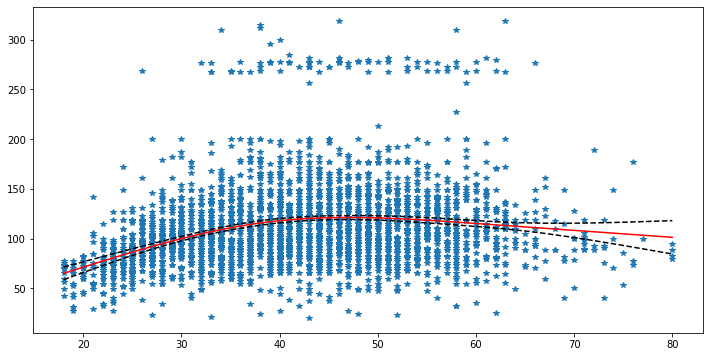

In [393]:
plt.figure(figsize=(12,6))
plt.plot(df.age, df.wage, "*")
plt.plot(grid, pred.predicted_mean, "r")
plt.plot(grid, pred.conf_int(), "k--")

In [396]:
model.params

Intercept             79.642095
cr(train, df=4)[0]   -14.667784
cr(train, df=4)[1]    36.811142
cr(train, df=4)[2]    35.934874
cr(train, df=4)[3]    21.563863
dtype: float64

In [420]:
def cubic_splines(data, degrees, intercept=True):
    return dmatrix(f"bs(train, df={degrees}, include_intercept={intercept})",
                  {"train":data},
                  return_type="dataframe")

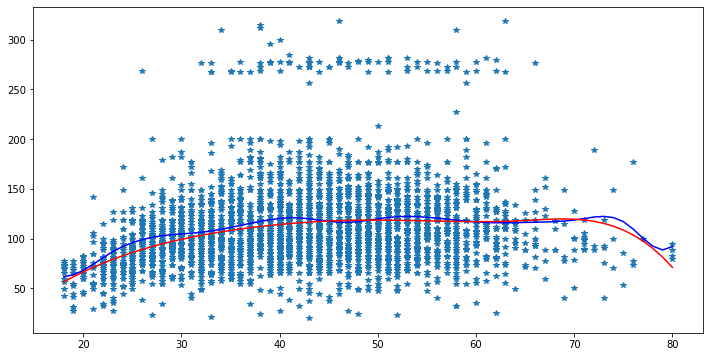

In [422]:
plt.figure(figsize=(12,6))
plt.plot(df.age, df.wage, "*")

X_train = cubic_splines(df.age, 16)
model1 = sm.GLM(df.wage, X_train).fit()
X1 = cubic_splines(grid,16)

pred1 = model1.get_prediction(X1)
plt.plot(grid, pred1.predicted_mean, "b")


X_train = cubic_splines(df.age, 7)
model2 = sm.GLM(df.wage, X_train).fit()
X2 = cubic_splines(grid, 7)

pred2 = model2.get_prediction(X2)
plt.plot(grid, pred2.predicted_mean, "r")

In [460]:
(xout,
 yout,
 wout)=loess_1d.loess_1d(df.age.to_numpy(), df.wage.to_numpy(), frac=0.2)

(xout2,
 yout2,
 wout2)=loess_1d.loess_1d(df.age.to_numpy(), df.wage.to_numpy(), frac=0.5)

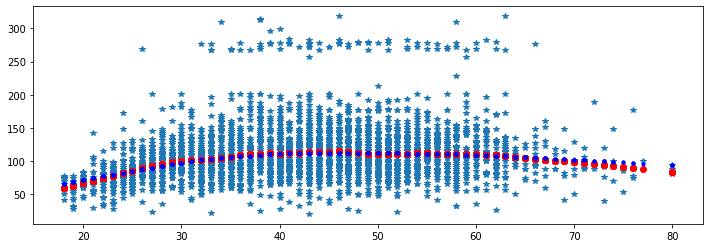

In [461]:
plt.figure(figsize=(12,4))
plt.plot(df.age, df.wage, "*")
plt.plot(xout, yout, "ro")
plt.plot(xout2, yout2, "b.")

## Generalized Additive Module